In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, precision_recall_curve, auc, ConfusionMatrixDisplay,average_precision_score
import matplotlib.pyplot as plt
import xgboost as xgb
import shap
import matplotlib.pyplot as plt
import joblib

In [4]:
df = pd.read_csv('dataset_final_para_modelo_1_100.csv', decimal=',')
df

,latitude,longitude,data,dia_semana,mes,is_weekend,hora,Sinistro,Chuva,tipo_via_num,tp_veiculo_bicicleta,tp_veiculo_caminhao,tp_veiculo_motocicleta,tp_veiculo_nao_disponivel,tp_veiculo_onibus,tp_veiculo_outros,tp_veiculo_automovel
0,-22.323152,-49.066030,2022-10-24,0,10,0,23,0,0,0.0,0,0,0,0,0,0,1
1,-22.330302,-49.106223,2023-03-02,3,3,0,12,0,0,0.0,0,0,0,0,0,0,1
2,-22.335932,-49.067196,2025-01-08,2,1,0,17,0,0,0.0,0,0,0,0,0,0,1
3,-22.327175,-49.116669,2024-01-23,1,1,0,19,0,0,0.0,0,0,0,0,0,0,1
4,-22.330951,-49.088352,2022-09-19,0,9,0,20,0,0,0.0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
827084,-22.309319,-49.073527,2025-01-16,3,1,0,15,0,0,0.0,0,0,1,0,0,0,0
827085,-22.325896,-49.079704,2024-05-17,4,5,0,9,0,0,0.0,0,0,0,0,0,0,1
827086,-22.351893,-49.032062,2024-02-01,3,2,0,13,0,0,0.0,0,0,0,0,0,0,1
827087,-22.291783,-49.071040,2022-07-10,6,7,1,9,0,0,0.0,0,0,0,0,0,0,1


In [5]:
X = df.drop(columns=['Sinistro', 'data']) 
 
y = df['Sinistro']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=9, stratify=y
)

print(f"Tamanho do conjunto de treino: {X_train.shape}")
print(f"Tamanho do conjunto de teste: {X_test.shape}")

Tamanho do conjunto de treino: (578962, 15)
Tamanho do conjunto de teste: (248127, 15)


### GridSearch

In [4]:
xgb_model = xgb.XGBClassifier(
    random_state=9,  
    eval_metric='logloss',
    use_label_encoder=False
)

param_dist = {
    'max_depth': [3, 5, 7, 10, 15],       # Testa profundidades diferentes
    'learning_rate': [0.01, 0.05, 0.1],  # Taxa de aprendizado
    'n_estimators': [200, 300, 400, 500], # Número de árvores
    'scale_pos_weight': [75, 100, 125],
    'subsample': [0.7, 0.8, 0.9, 1.0],      # Amostragem de linhas
    'colsample_bytree': [0.7, 0.8, 0.9, 1.0], # Amostragem de colunas
    'gamma': [0, 0.5, 1, 5]                 # Regularização de poda
}

random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=20,                    # Teste 20 combinações aleatórias
    scoring='average_precision',
    cv=3,
    verbose=2,
    n_jobs=-1,
    random_state=42
)

# 4. Execute a busca
print("Iniciando RandomizedSearchCV (otimizado para PR-AUC)...")
random_search.fit(X_train, y_train)
print("Busca concluída.")

# 5. Veja os melhores parâmetros
print("\nMelhores parâmetros encontrados:")
print(random_search.best_params_)

# 6. Veja o melhor score
print("\nMelhor score (Average Precision):")
print(random_search.best_score_)

Iniciando RandomizedSearchCV (otimizado para PR-AUC)...
Fitting 3 folds for each of 20 candidates, totalling 60 fits


c:\Users\pirsp\Documents\TCC\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [23:49:15] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Busca concluída.

Melhores parâmetros encontrados:
{'subsample': 0.9, 'scale_pos_weight': 75, 'n_estimators': 300, 'max_depth': 7, 'learning_rate': 0.05, 'gamma': 5, 'colsample_bytree': 0.8}

Melhor score (Average Precision):
0.8646823151619621


### Treinando o modelo com os melhores parâmetros

In [6]:
xgb_model_final = xgb.XGBClassifier(
    random_state=9,
    subsample = 0.9,
    scale_pos_weight = 75,
    n_estimators = 300,
    max_depth = 7, 
    learning_rate = 0.05, 
    gamma = 5, 
    colsample_bytree = 0.8,
    eval_metric='logloss',
)

xgb_model_final.fit(X_train, y_train)

joblib.dump(xgb_model_final, 'src/model/modelo_risco_viario_3.pkl')

['src/model/modelo_risco_viario_3.pkl']

### Métricas

--- Métricas com Limiar Fixo de 0.5 ---
              precision    recall  f1-score   support

           0       1.00      0.99      0.99    245670
           1       0.37      0.85      0.52      2457

    accuracy                           0.98    248127
   macro avg       0.68      0.92      0.75    248127
weighted avg       0.99      0.98      0.99    248127


--- Matriz de Confusão ---


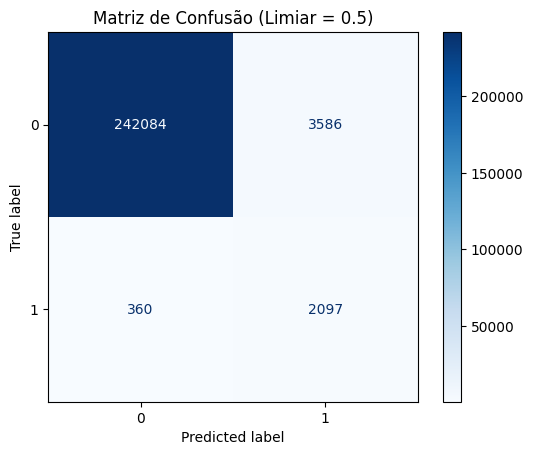


--- AUC (ROC) ---
ROC-AUC: 0.9655

--- Curva Precision-Recall (PR-AUC) ---
Average Precision (AP) / PR-AUC: 0.8532


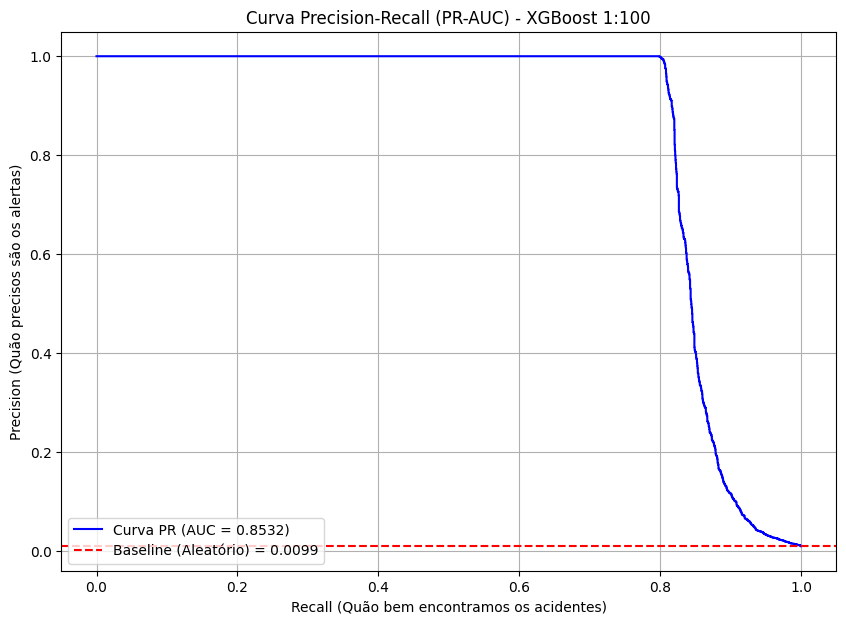

In [17]:
y_prob_xgb = xgb_model_final.predict_proba(X_test)[:, 1]

# 2. Definir o limiar e obter predições binárias
# (Pode ajustar este limiar com base na sua análise da curva PR)
LIMIAR_ESCOLHIDO = 0.5
y_pred_final = (y_prob_xgb >= LIMIAR_ESCOLHIDO).astype(int)

print(f"--- Métricas com Limiar Fixo de {LIMIAR_ESCOLHIDO} ---")
print(classification_report(y_test, y_pred_final))

# 3. Calcular Matriz de Confusão
print("\n--- Matriz de Confusão ---")
cf_matrix = confusion_matrix(y_test, y_pred_final)
ConfusionMatrixDisplay(cf_matrix).plot(cmap=plt.cm.Blues)
plt.title(f"Matriz de Confusão (Limiar = {LIMIAR_ESCOLHIDO})")
plt.show()

# ==============================================================
# --- AVALIAÇÃO INDEPENDENTE DE LIMIAR (MÉTRICAS GERAIS) ---
# ==============================================================

# 4. Calcular ROC-AUC (Métrica de performance geral)
auc_xgb = roc_auc_score(y_test, y_prob_xgb)
print(f"\n--- AUC (ROC) ---")
print(f"ROC-AUC: {auc_xgb:.4f}")

# 5. Calcular e Plotar a Curva Precision-Recall (PR-AUC)
print("\n--- Curva Precision-Recall (PR-AUC) ---")

# Calcular Precision, Recall e Limiares
precision, recall, thresholds = precision_recall_curve(y_test, y_prob_xgb)

# Calcular a Área sob a Curva (PR-AUC)
pr_auc = auc(recall, precision)
avg_precision = average_precision_score(y_test, y_prob_xgb)

print(f"Average Precision (AP) / PR-AUC: {avg_precision:.4f}")

# Plotar o gráfico
plt.figure(figsize=(10, 7))
plt.plot(recall, precision, color='b', label=f'Curva PR (AUC = {pr_auc:.4f})')

# Plotar a Linha de Base (Baseline)
# Representa um modelo que chuta aleatoriamente
n_positivos = y_test.sum()
n_total = len(y_test)
baseline = n_positivos / n_total
plt.axhline(y=baseline, color='r', linestyle='--', label=f'Baseline (Aleatório) = {baseline:.4f}')

# Configurações do gráfico
plt.title('Curva Precision-Recall (PR-AUC) - XGBoost 1:100')
plt.xlabel('Recall (Quão bem encontramos os acidentes)')
plt.ylabel('Precision (Quão precisos são os alertas)')
plt.legend(loc='lower left')
plt.grid(True)
plt.show()